# Spike Train Generation
## 1. MNIST Conversion to Spike Train
### 1.1. Import packages and setup environment

In [1]:
# Note to self: from snntorch import utils is not needed as that is in __init__

import torch
import os
import sys

# Note to self: when running locally, I need to change directory to the following path
os.chdir("C:\\Users\\Jason\\Dropbox\\repos\\snntorch")

# when running on colab, use this line to add it to the search path:
sys.path.insert(0, '/content/snntorch')

import snntorch as snn
from snntorch.spikevision import datamod, spikegen

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Initialize the configuration file which contains information about the dataset.

The first input refers to the first two dataset dimensions. `channels` is the third dimension (i.e., depth).

`split` can be used to assign data from the training to the the validation set.
*E.g., for a split of 0.2, the validation set will be made up of 20% of the train set.*

`subset` is used to partition the training and test sets down by the given factor.
*E.g., for a subset of 100, a training set of 60,000 will be reduced to 600.*

`num_classes` is the number of output classes (10 for MNIST).

 `T` is the number of time steps to be simulated.

 Finally, `data_path` is the directory to which your training set will be downloaded to, if using torchvision.

In [2]:
config = snn.utils.Configuration([28,28], channels=1, batch_size=100, split=0.1, subset=100, num_classes=10, T=1000,
                           data_path='/data/mnist')

### 1.2 Download Dataset

Note that we are creating a dataset `mnist_val` which is equivalent to `mnist_train`.
This allows us to retain the `data` and `target` attributes which would otherwise be lost had we used `random_split`.

In [3]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize(config.input_size),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(config.data_path, train=True, download=True, transform=transform)
mnist_val = datasets.MNIST(config.data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(config.data_path, train=False, download=True, transform=transform)

Create train/validation split using the value in `config.split`.

`spikevision` is a subpackage within `snntorch` containing useful modules for modifying the data set.
Many such functions are called from the package `datamod`.

In [4]:
from snntorch.spikevision import datamod

mnist_train, mnist_val = datamod.valid_split(mnist_train, mnist_val, config)

Reduce training, validation and test sets to smaller subsets as defined in `config.subset`.

In [5]:
mnist_train = datamod.data_subset(mnist_train, config)
mnist_val = datamod.data_subset(mnist_val, config)
mnist_test = datamod.data_subset(mnist_test, config)

As a quick sanity check, let's take a look at the length of each of our datasets:

In [6]:
print(f"The size of mnist_train is {len(mnist_train)}")
print(f"The size of mnist_val is {len(mnist_val)}")
print(f"The size of mnist_test is {len(mnist_test)}")

The size of mnist_train is 540
The size of mnist_val is 60
The size of mnist_test is 100


### 1.3 Create Dataloaders

In [7]:
from torch.utils.data import DataLoader

# Note to self: after each dataloader object, append ".to(device)"
train_loader = DataLoader(mnist_train, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=config.batch_size, shuffle=True)

### 1.4 Spike Train Generation
We now need to convert static images from MNIST into a spike train. Ideally, this would be done in one single batch.
But this will often exceed memory capacity as the size of a dataset would be multiplied by the number of time steps.
*E.g., a 45 MB MNIST dataset simulated for T=1,000 time steps would be 45GB.*

To avoid this issue, minibatches of spikes must be re-calculated every time they are called.

In [8]:
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data --------- should calculate this on cuda, test on colab.
spike_data, spike_targets = spikegen.spike_conversion(data_it, targets_it, config)

#### 1.4.1 Visualising Data
The `spikeplot` module contains useful functions for visualising spiking data. Let's index into one sample from
`spike_data`, where it is of dimensions [T x B x C x W x H], and must be reduced to [T x W x H].

In [9]:
from snntorch import spikeplot
# Note to Self: I only needed matplotlib.use("TkAgg") for use in PyCharm.
import matplotlib; matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

spike_data_visualizer = spike_data[:,0,0]
data_sample = spikeplot.spike_animator(spike_data_visualizer, x=28, y=28, T=100)
#plt.show()


# If the above code doesn't work in Colab, then modify spikeplot to the following. Need to test:
#from IPython.display import HTML
#plt.close(fig)
#print(spike_targets[0][0])
#HTML(data_sample.to_html5_video())

#however, HTML required installation of ffmpeg package. Not ideal.
#### I should come up with a more general solution.

And the associated label can be indexed as follows:

In [10]:
import numpy as np

print(f"The target is: {np.argmax(spike_targets[0][:][0], axis=0)}")

The target is: 6


As a matter of interest, let's do that again but with 25% of the gain for increased sparsity:

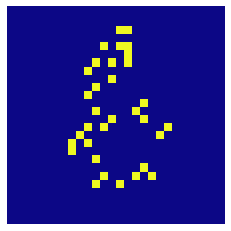

In [11]:
spike_data, spike_targets = spikegen.spike_conversion(data_it, targets_it, config, gain=0.25)
spike_data_visualizer = spike_data[:,0,0]
data_sample = spikeplot.spike_animator(spike_data_visualizer, x=28, y=28, T=100)
plt.show()

#### To-do: 1) append ".to(device)" to dataloaders
#### To-do: 2) include functionality for the following datasets, as we will need to benchmark:
##### a) CIFAR-10 converted to spikes
##### b) NMNIST
##### c) N-CIFAR-10?
##### d) DVS Gesture
##### d) EEG from Enea's Frontiers paper
##### e)

### 2.0 LIF Neuron & Architecture